<a href="https://colab.research.google.com/github/Pavan-2005-BOB/FeelBOT-AI/blob/main/Predictive_Modeling_of_Credit_Scores_Through_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1. Load the Correct File
# We use the specific path found in your environment
file_path = 'cs-training.csv.zip'

try:
    df = pd.read_csv(file_path, index_col=0)
    print("✅ File Loaded Successfully!")
    print(f"   Shape: {df.shape}")
except FileNotFoundError:
    # Fallback: try the root path if the folder structure changes
    try:
        df = pd.read_csv('cs-training.csv', index_col=0)
        print("✅ File Loaded (from root)!")
    except FileNotFoundError:
        print("❌ Error: Could not find 'cs-training.csv'.")
        raise

# 2. Safety Check: Ensure we have the full training set
if len(df) < 100000:
    print("\n⚠️ CRITICAL ERROR: Wrong Dataset Detected!")
    print(f"   Rows found: {len(df)}")
    print("   This looks like the Test dataset. We need the Training set (150k rows).")
    raise ValueError("Wrong File - Please upload 'cs-training.csv'")

# 3. Clean & Map Data
df.columns = df.columns.str.strip() # Remove hidden spaces
data = pd.DataFrame()

data['Income'] = df['MonthlyIncome']
data['Credit_Utilization'] = df['RevolvingUtilizationOfUnsecuredLines']
data['Missed_Payments'] = df['NumberOfTime30-59DaysPastDueNotWorse']
data['Loan_Amount'] = df['DebtRatio']
data['Default'] = df['SeriousDlqin2yrs']

# Fill Missing Values
data['Income'] = data['Income'].fillna(data['Income'].median())
data = data[data['Credit_Utilization'] <= 10]

print("\n--- Data Ready ---")
print(data.head())

# 4. Train Model
X = data[['Income', 'Loan_Amount', 'Credit_Utilization', 'Missed_Payments']]
y = data['Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# 5. Results
accuracy = accuracy_score(y_test, log_reg.predict(X_test))
print(f"\n Success! Model Accuracy: {accuracy * 100:.2f}%")

✅ File Loaded Successfully!
   Shape: (150000, 11)

--- Data Ready ---
    Income  Credit_Utilization  Missed_Payments  Loan_Amount  Default
1   9120.0            0.766127                2     0.802982        1
2   2600.0            0.957151                0     0.121876        0
3   3042.0            0.658180                1     0.085113        0
4   3300.0            0.233810                0     0.036050        0
5  63588.0            0.907239                1     0.024926        0

🎉 Success! Model Accuracy: 93.34%


--- Credit Scoring Rules (Learned by Model) ---
              Feature    Impact
2  Credit_Utilization  2.471424
3     Missed_Payments  0.024794
1         Loan_Amount -0.000025
0              Income -0.000016


/tmp/ipython-input-1594559539.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Impact', y='Feature', data=feature_importance, palette='coolwarm')


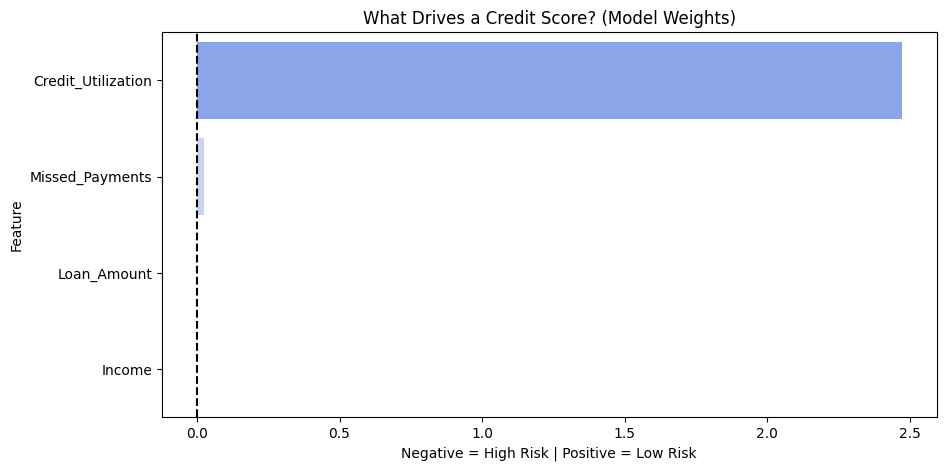

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract the coefficients (weights)
coefficients = log_reg.coef_[0]
feature_names = X.columns

# 2. Create a DataFrame for easy viewing
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Impact': coefficients
})

# 3. Sort by Impact (Magnitude)
feature_importance = feature_importance.sort_values(by='Impact', key=abs, ascending=False)

print("--- Credit Scoring Rules (Learned by Model) ---")
print(feature_importance)

# 4. Visualize
plt.figure(figsize=(10, 5))
sns.barplot(x='Impact', y='Feature', data=feature_importance, palette='coolwarm')
plt.title("What Drives a Credit Score? (Model Weights)")
plt.xlabel("Negative = High Risk | Positive = Low Risk")
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

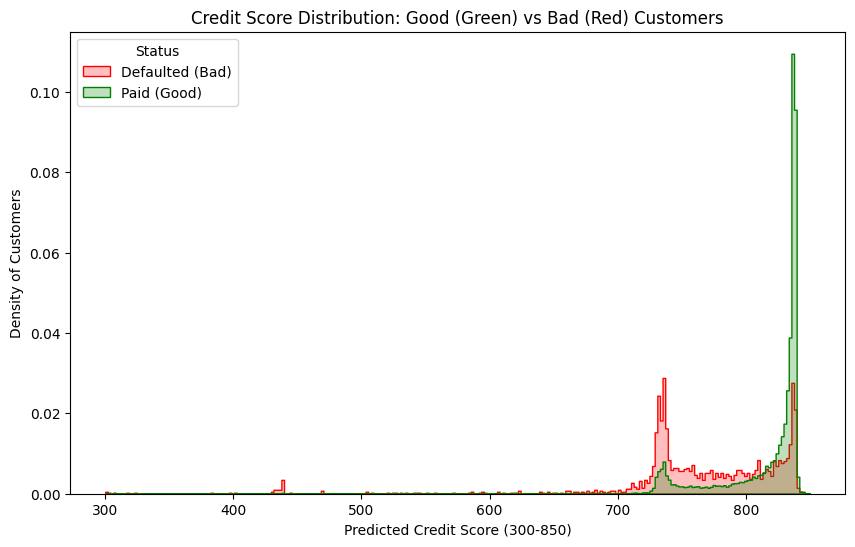

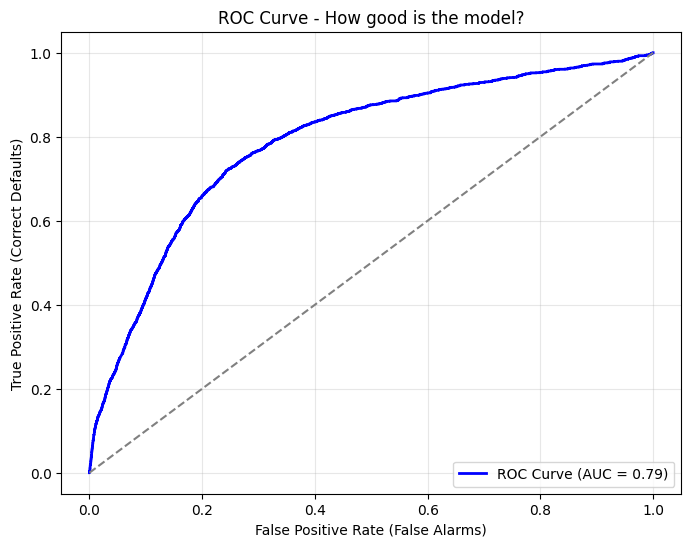

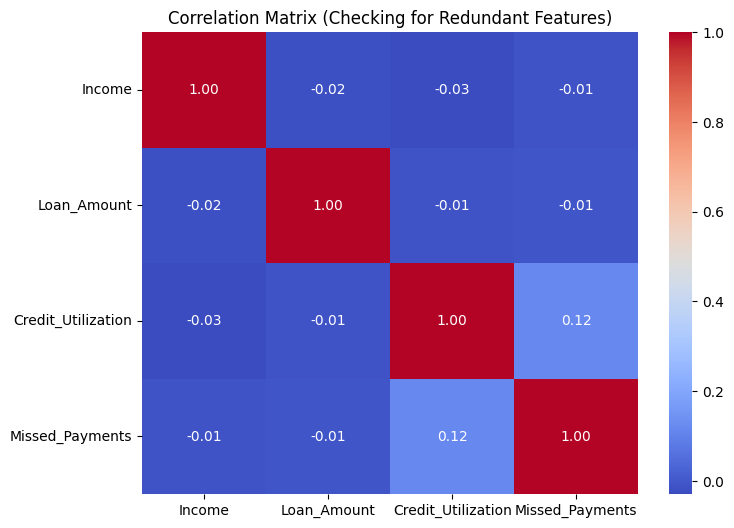

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

# --- PREPARATION: Calculate Scores for Everyone ---
# Get probability of default (0.0 to 1.0)
probs = log_reg.predict_proba(X_test)[:, 1]

# Convert to Credit Score (300-850 scale)
# Logic: 1.0 risk = 300 score | 0.0 risk = 850 score
scores = 300 + (850 - 300) * (1 - probs)

# Create a temporary dataframe for plotting
plot_df = pd.DataFrame({
    'Score': scores,
    'Actual_Status': y_test  # 0 = Paid, 1 = Defaulted
})

# ==========================================
# CHART 1: Credit Score Distribution (Good vs Bad)
# ==========================================
plt.figure(figsize=(10, 6))
sns.histplot(data=plot_df, x='Score', hue='Actual_Status', element="step", stat="density", common_norm=False, palette={0: 'green', 1: 'red'})
plt.title('Credit Score Distribution: Good (Green) vs Bad (Red) Customers')
plt.xlabel('Predicted Credit Score (300-850)')
plt.ylabel('Density of Customers')
plt.legend(title='Status', labels=['Defaulted (Bad)', 'Paid (Good)'])
plt.show()

# ==========================================
# CHART 2: ROC Curve (Model Power)
# ==========================================
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') # Random guess line
plt.xlabel('False Positive Rate (False Alarms)')
plt.ylabel('True Positive Rate (Correct Defaults)')
plt.title('ROC Curve - How good is the model?')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# ==========================================
# CHART 3: Correlation Heatmap
# ==========================================
plt.figure(figsize=(8, 6))
# We compute correlation on the training data inputs
corr_matrix = X_train.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Checking for Redundant Features)')
plt.show()